# DATA 604 Final Project:  Simulation of COVID-19 Vaccine Administration
## *Deepika Dilip*

## Introduction
In December 2020, hospitals released the first doses of the COVID-19 vaccine. Populations were tiered per demographic criteria, including employment at a major hospital, being an at-risk population, etc. The process became chaotic and was openly mocked, to the point that unused doses were rushed to local prisons to avoid waste. **Here, I simulate a simple COVID-19 vaccine site, inspired by my own experience when getting the vaccine from my employer (a hospital cancer center).**

## Methods: Simulation Workflow

In [161]:
import simpy
import numpy as np
import pandas as pd
import random
import itertools 
import matplotlib.pyplot as plt


The first step here is defining a vaccine clinic that contains all the functions I'll be using. Below is the **VaccineClinic** that contains a parameter for COVID-19 prevalence, along with nurse/staff counts. This is followed by the following processes:

* `def_check_in`: Checking in at the front desk
* `covid_shot_healthy`: Receiving the shot + waiting afterwards
* `covid_shot_risk`: Receiving the shot + waiting afterwards for at-risk populations

In [89]:
class VaccineClinic(object):
    def __init__(self, env, num_staff, num_nurses, covid_prob):
        self.env = env
        self.staff = simpy.Resource(env, num_staff)
        self.nurse = simpy.Resource(env, num_nurses)
        self.covid_prob = covid_prob
    def check_in(self, patient):
        wait_time = random.randrange(5, 20) # Check-in time
        wait_time_total['Patient'].append(patient)
        wait_time_total['Total Wait Time'].append(wait_time)  # Storing the front desk wait time
        yield self.env.timeout(wait_time)
    def covid_shot_risk(self, patient):
 #       at_risk = random.random() < random.uniform(0, 0.1)
        vaccine_time = random.randrange(10, 20)
        post_vaccine_time = random.randrange(40, 60)
#        print(patient, 'is at risk and is waiting post-vax')
        total_time =  vaccine_time + post_vaccine_time # Metrics
        yield self.env.timeout(total_time)
        time_total_d['Patient'].append(patient)
        time_total_d['Total Vax Time'].append(total_time)


        print(patient, "got vaccine in", total_time, " minutes")
    def covid_shot_healthy(self, patient):
        vaccine_time = random.randrange(10, 20)
        post_vaccine_time = random.randrange(10, 20)
#        print(patient, 'is not at risk and waiting post-vax')
        total_time =  vaccine_time + post_vaccine_time # Metrics
        yield self.env.timeout(total_time)
        time_total_d['Patient'].append(patient)
        time_total_d['Total Vax Time'].append(total_time)
        
        print(patient, "got vaccine in a total of", total_time, " minutes")



Here we define the `patient` who goes through the schema listed later. 

In [122]:
def patient(env, name, vc):
#    covid = random.random() < random.uniform(0, 0.05) 
    covid = random.random() < random.uniform(0, vc.covid_prob )
#    print(str(covid))
    """Boolean for whether patient  has COVID"""
    at_risk= random.random() < random.uniform(0, 0.22)
    """Boolean for whether patient is at risk"""
    
    with vc.staff.request() as request: # First request at the front desk
        yield request
#        print(name, 'arrives for check in')
        yield env.process(vc.check_in(name))
    if covid is True: # COVID patients can't get vaccine
        print(name, 'has COVID and rescheduled')
        covid_count.append(name)
    else:
        with vc.nurse.request() as request: # Second request fo a nurse/vaccine
            yield request
            if at_risk is True:
#                print(name, '(at risk) gets shot')
                yield env.process(vc.covid_shot_risk(name))  
#                print(name, 'leaves')
            else:
#                print(name, '(not at risk) gets shot')
                yield env.process(vc.covid_shot_healthy(name)) 
#                print(name, 'leaves')

Lastly, we set up the environment, starting with two patients and then add two per time interval. 

In [123]:
def setup(env, num_staff, num_nurses, t_inter, covid_prob):
    """Initiates two patients to check in and then creates more patients 
    entering the clinic"""
    # Create the vaccine clinic
    vc = VaccineClinic(env, num_staff, num_nurses, covid_prob)

    # 2 initial patients
    for i in range(2):
        env.process(patient(env,  'Patient %d' % i,  vc))

    # More patients
    while True:
        yield env.timeout(random.randint(t_inter - 2, t_inter + 2))
        i += 1
        env.process(patient(env,  'Patient %d' % i,  vc))


### Flow Chart
In total, the model looks like this:
![flowchart](flow_diagram.png)

Some points I took into consideration:
1. Individuals with COVID-19 **cannot** get the vaccine. Their appointment needs to be rescheduled. This is also where the COVID-19 prevalence of the region kicks in. 
2. COVID-19 prevalence also affects staff and nurse availability.
3. Individuals with co-morbidities will require extra monitoring at the end of their shot.


## Methods: Verification
Let's see if the model works! Here, I'll incorporate the COVID-19 prevalence in the staffing/nurse counts (people will be taking time off, hopefully). Just to see if this is working, I'll use a COVID-19 prevalence of 5%. I'll run this for 480 interations (or an 8 hour workday, because I want to visualize this on a daily basis). I'll also set the time interval for 15 minutes, because appointments are usually scheduled every quarter of the hour.  

In [155]:
# Parameters
STAFF_COUNT = 3  * (1- COVID_PROB) # 3 staffers are usually at the front desk
TIME_INTERVAL = 15 # Appointments are usually scheduled every 15 minutes 
COVID_PROB = 0.05 # COVID-19 prevalence 
NURSE_COUNT = 15 * (1- COVID_PROB) # Ideally there will be 15 nurses. This number will change per COVID-19 prevalence

# Objects we'll use to capture results
covid_count = [] # Patients with COVID
wait_time_total = {'Patient':[], 'Total Wait Time': []} # Wait Time per patient
time_total_d = {'Patient':[], 'Total Vax Time': []} # Vax Time per patient

env = simpy.Environment()
env.process(setup(env, num_staff = STAFF_COUNT, num_nurses = NURSE_COUNT, t_inter = TIME_INTERVAL, covid_prob = COVID_PROB))
env.run(until = 480) 
# We'll do this for 480 iterations (minutes) since we're looking at a 9-5 workday


Patient 1 got vaccine in a total of 34  minutes
Patient 0 got vaccine in a total of 31  minutes
Patient 2 got vaccine in a total of 30  minutes
Patient 4 got vaccine in a total of 36  minutes
Patient 6 got vaccine in a total of 29  minutes
Patient 3 got vaccine in 69  minutes
Patient 7 got vaccine in a total of 24  minutes
Patient 8 got vaccine in a total of 25  minutes
Patient 5 got vaccine in 61  minutes
Patient 9 got vaccine in a total of 28  minutes
Patient 10 got vaccine in a total of 28  minutes
Patient 11 got vaccine in a total of 27  minutes
Patient 12 got vaccine in a total of 24  minutes
Patient 13 got vaccine in a total of 31  minutes
Patient 15 got vaccine in a total of 26  minutes
Patient 16 got vaccine in a total of 27  minutes
Patient 14 got vaccine in 68  minutes
Patient 17 got vaccine in a total of 28  minutes
Patient 18 got vaccine in a total of 22  minutes
Patient 19 got vaccine in a total of 34  minutes
Patient 20 got vaccine in a total of 26  minutes
Patient 21 got

## Methods: COVID-19 at 5%
Here, I'll run the simulation, assuming COVID-19 prevalence is at 5%. I'll do this for 30 days, and we can visualize the results

In [156]:
%%capture
# Next Step, doing this for a month.
# Parameters
STAFF_COUNT = 3 * (1- COVID_PROB)  # 3 staffers are usually at the front desk
TIME_INTERVAL = 15 # Appointments are usually scheduled every 15 minutes 
COVID_PROB = 0.05 # COVID-19 prevalence 
NURSE_COUNT = 10 * (1- COVID_PROB) # Ideally there will be 10 nurses. This number will change per COVID-19 prevalence


seed_no = range(30)
month_total_patients_5 = [] # Total number of patients who arrived at check in per day
month_covid_patients_5 = [] # Total number of COVID patients per day
month_total_vax_patients_5 = [] # Patients who got vaccinated per day
month_mean_vax_time_5 = [] # Mean time it took to get vaccinated per day

for i in range(30):
    random.seed(seed_no[i])
    
    # METRICS
    covid_count = [] # Patients with COVID
    wait_time_total = {'Patient':[], 'Total Wait Time': []} # Wait Time per patient
    time_total_d = {'Patient':[], 'Total Vax Time': []} # Vax Time per patient
    
    # RUN SIMULATION
    env = simpy.Environment()
    env.process(setup(env, num_staff = STAFF_COUNT, num_nurses = NURSE_COUNT, t_inter = TIME_INTERVAL, covid_prob = COVID_PROB))
    env.run(until = 480) 
    
    # STORE DATA
    month_total_patients_5.append(len(wait_time_total['Patient']))
    month_covid_patients_5.append(len(covid_count))
    month_total_vax_patients_5.append(len(time_total_d['Patient']))
    month_mean_vax_time_5.append(np.mean(time_total_d['Total Vax Time']))
                                
    

### Patients Vaccinated 
Here, I'll depict a histogram of patients vaccinated daily at the clinic. The distribution is (somewhat), normal, with a median of 29 patients getting the jab.

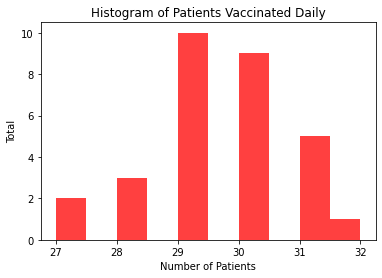

In [157]:
plt.hist(month_total_vax_patients_5, density=False, facecolor='r', alpha=0.75)
plt.xlabel('Number of Patients')
plt.ylabel('Total')
plt.title('Histogram of Patients Vaccinated Daily')
plt.show()

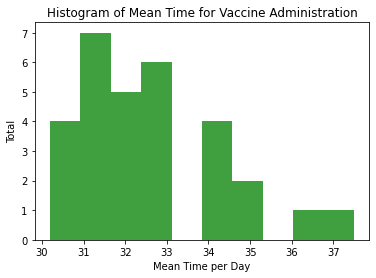

In [160]:

plt.hist(month_mean_vax_time_5, density=False, facecolor='g', alpha=0.75)
plt.xlabel('Mean Time per Day')
plt.ylabel('Total')
plt.title('Histogram of Mean Time for Vaccine Administration')
plt.show()


### Vaccine Administration
Here, I'll visualize the average time it took for an individual to get the vaccine (getting the shot and waiting afterwards). Data is skewed right, with most individuals taking ~32 minutes (a couple take longer and are most likely individuals at risk for an adverse reaction later)

And to check, here's the number of COVID-19 patients who arrived at the clinic per day

Here is the number of patients who got their shot per day

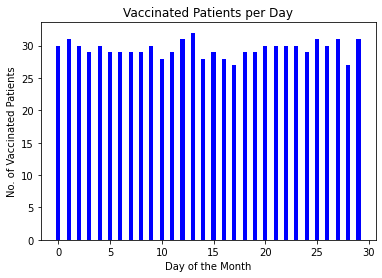

In [148]:
plt.bar(range(30), month_total_vax_patients_5, color ='blue',
        width = 0.4)
plt.xlabel("Day of the Month")
plt.ylabel("No. of Vaccinated Patients")
plt.title("Vaccinated Patients per Day")
plt.show()

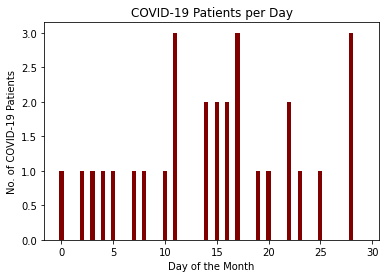

In [159]:
plt.bar(range(30), month_covid_patients_5, color ='maroon',
        width = 0.4)
plt.xlabel("Day of the Month")
plt.ylabel("No. of COVID-19 Patients")
plt.title("COVID-19 Patients per Day")
plt.show()

## Methods: COVID-19 at 25%
Here, I'll run the simulation, assuming COVID-19 prevalence is at 25%

In [150]:
%%capture
# Next Step, doing this for a month.
# Parameters
STAFF_COUNT = 3 * (1- COVID_PROB) # 3 staffers are usually at the front desk
TIME_INTERVAL = 15 # Appointments are usually scheduled every 15 minutes 
COVID_PROB = 0.25 # COVID-19 prevalence 
NURSE_COUNT = 10 * (1- COVID_PROB) # Ideally there will be 10 nurses. This number will change per COVID-19 prevalence


seed_no = range(60, 90, 1)
month_total_patients_25 = [] # Total number of patients who arrived at check in per day
month_covid_patients_25 = [] # Total number of COVID patients per day
month_total_vax_patients_25 = [] # Patients who got vaccinated per day
month_mean_vax_time_25 = [] # Mean time it took to get vaccinated per day

for i in range(30):
    random.seed(seed_no[i])
    
    # METRICS
    covid_count = [] # Patients with COVID
    wait_time_total = {'Patient':[], 'Total Wait Time': []} # Wait Time per patient
    time_total_d = {'Patient':[], 'Total Vax Time': []} # Vax Time per patient
    
    # RUN SIMULATION
    env = simpy.Environment()
    env.process(setup(env, num_staff = STAFF_COUNT, num_nurses = NURSE_COUNT, t_inter = TIME_INTERVAL, covid_prob = COVID_PROB))
    env.run(until = 480) 
    
    # STORE DATA
    month_total_patients_25.append(len(wait_time_total['Patient']))
    month_covid_patients_25.append(len(covid_count))
    month_total_vax_patients_25.append(len(time_total_d['Patient']))
    month_mean_vax_time_25.append(np.mean(time_total_d['Total Vax Time']))
                                
    

### Plots
Here, I replicate the plots. The results are in accordance with the following:
* Fewer patients are vaccinated when COVID-19 prevalence is higher
* It takes longer to get vaccinated if COVID-19 prevalence is higher (most likely because of staffing shortages)


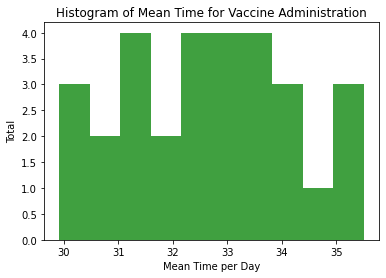

In [151]:
import matplotlib.pyplot as plt
plt.hist(month_mean_vax_time_25, density=False, facecolor='g', alpha=0.75)
plt.xlabel('Mean Time per Day')
plt.ylabel('Total')
plt.title('Histogram of Mean Time for Vaccine Administration')
plt.show()


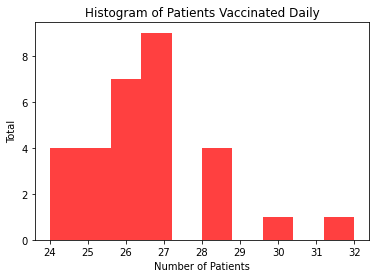

In [154]:
plt.hist(month_total_vax_patients_25, density=False, facecolor='r', alpha=0.75)
plt.xlabel('Number of Patients')
plt.ylabel('Total')
plt.title('Histogram of Patients Vaccinated Daily')
plt.show()

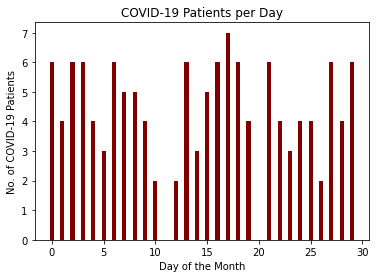

In [152]:
plt.bar(range(30), month_covid_patients_25, color ='maroon',
        width = 0.4)
plt.xlabel("Day of the Month")
plt.ylabel("No. of COVID-19 Patients")
plt.title("COVID-19 Patients per Day")
plt.show()

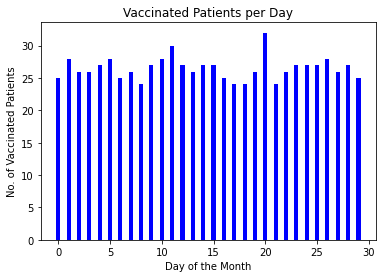

In [153]:
plt.bar(range(30), month_total_vax_patients_25, color ='blue',
        width = 0.4)
plt.xlabel("Day of the Month")
plt.ylabel("No. of Vaccinated Patients")
plt.title("Vaccinated Patients per Day")
plt.show()

## Limitations
The model has the following limitations

* Does not account for adverse responses to the vaccine: these were quite rare, so I excluded it for now. 
* Vaccine supply is unlimited here. I think this is fair, given the federal expansion of vaccine availability, but this might not be the case in a medically-underserved region.
* COVID-19 surveillance: this model takes in COVID-19 prevalence and hits an estimate. As we know, surveillance is flawed, due to municipalities not reporting rapid tests and lag in data reporting.

## Discussion
* If there’s a high incidence of COVID-19 in the area, more folks are going to be ineligible for the vaccine. This in turn could influence staffing decisions
* Real life example of resource scarcity: during the COVID-29 surge in December 2021, hospital staff were redeployed across the cancer center. Nurses were calling in sick. Individuals who were not trained were still sent to serve the front desk of a vaccination site. If vaccine sites administer fewer vaccines since more patients are getting COVID-19, employees should (theoretically) be deployed somewhere else for efficiency.